In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import jax.numpy as jnp 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train=pd.read_csv('FLIM.csv', index_col=0)

,Protein,Plasmem,Time_AD,Date,Mol_ID,y_scaled,x_scaled
0,EphB1D,0.0,3.410,221011,3,0.106160,0.0
1,EphB1D,0.0,3.348,221011,3,0.122412,0.0
2,EphB1D,0.0,3.600,221011,3,0.056356,0.0
3,EphB1D,0.0,3.563,221011,3,0.066055,0.0
4,EphB1D,0.1,3.366,221011,3,0.117693,0.1


In [3]:
def plateFRET_s(x, c):
    y = x / (x + c) 
    return y


In [4]:
def model_FretS_hie(Mol_ID, x_scaled, y_scaled=0):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))

    n_Mol_ID = len(np.unique(Mol_ID))

    with numpyro.plate("plate_i", n_Mol_ID):
        α = numpyro.sample("α", dist.HalfNormal(μ_α))

    sc = numpyro.sample('sc', dist.Normal(0,5) )

    mu = plateFRET_s(x_scaled, α[Mol_ID])
    
    with numpyro.plate("N", len(x_scaled)):
        numpyro.sample('obs', dist.Normal(mu, sc),  obs = y_scaled)

In [5]:
# Acceptor density  to Mol% from data of MemGlow590
xscale_factor = 0.001

In [6]:
x_scaled = train['x_scaled'].values*xscale_factor
y_scaled = train['y_scaled'].values
Mol_ID= train['Mol_ID'].values

In [7]:
nuts = numpyro.infer.NUTS(model_FretS_hie)

mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), Mol_ID, x_scaled, y_scaled)

trace = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

<ipython-input-7-80c92331251e>:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100%|██████████| 3500/3500 [00:00<00:00, 4522.55it/s, 63 steps of size 7.44e-02. acc. prob=0.91]


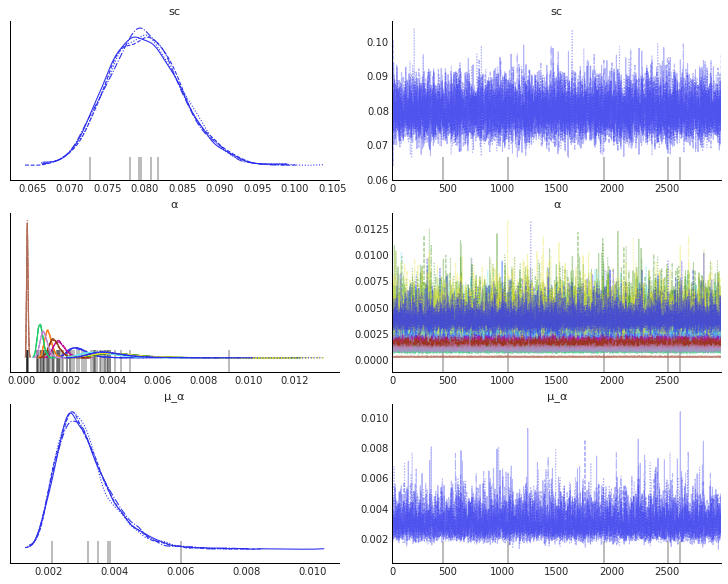

In [8]:
az.style.use("arviz-white")
az.plot_trace(idata,figsize=(10, 8));

In [9]:
def create_prediction_template(unique_Mol_ID, X_range):
    unique_Mol_ID["_temp"] = True
    X_temp = pd.DataFrame(X_range, columns=["X"])
    X_temp["_temp"] = True
    return unique_Mol_ID.merge(X_temp, on="_temp").drop(["_temp"], axis=1)

In [10]:
u_Mol_ID = train[["Protein", "Mol_ID"]].drop_duplicates()
X_range = jnp.linspace(0, 1*xscale_factor*2, 25*2)
pred_template = create_prediction_template(u_Mol_ID, X_range)

In [11]:
pf_Mol_ID = pred_template["Mol_ID"].values
pf_x_scaled = pred_template["X"].values
predictive = numpyro.infer.Predictive(model_FretS_hie, trace)
ppc_samples = predictive(jax.random.PRNGKey(1), pf_Mol_ID, pf_x_scaled, None)
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [12]:
df_ppc = pred_template.copy()
df_ppc["Y_pred"] = ppc_samples["obs"].T.mean(axis=1)
df_ppc["sigma"] = ppc_samples["obs"].T.std(axis=1)
# HDI (Highest Density interval) Mean +/- sigma --> 68% CI (Confidence Interval)
df_ppc["Y_inf"] = df_ppc["Y_pred"] - df_ppc["sigma"]
df_ppc["Y_sup"] = df_ppc["Y_pred"] + df_ppc["sigma"]

In [13]:
N_Mol_ID = len(np.unique(Mol_ID))

In [14]:
def chart_predictions(Mol_Name, ax):
    data_ppc = df_ppc[df_ppc["Protein"] == Mol_Name]
    x_ppc = data_ppc["X"].values
    data_obs = train[train['Protein']== Mol_Name]
    x_obs = data_obs['x_scaled'].values*xscale_factor
    ax.set_title(Mol_Name)
    ax.set_xlim(-0.1*xscale_factor, xscale_factor*2.1)
    ax.set_ylim(-0.1, 1)
    ax.plot(x_obs, data_obs["y_scaled"], "o", markersize=12, color="black")
    ax.plot(x_ppc, data_ppc["Y_pred"].values, lw=6, alpha=1, color="red")
    ax.hlines(y=0, xmin = 0, xmax = 3, colors = "grey", linestyles='dashed')
    ax.fill_between(x_ppc, data_ppc["Y_inf"], data_ppc["Y_sup"], color="lavender")

<ipython-input-15-8f19993d28b4>:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


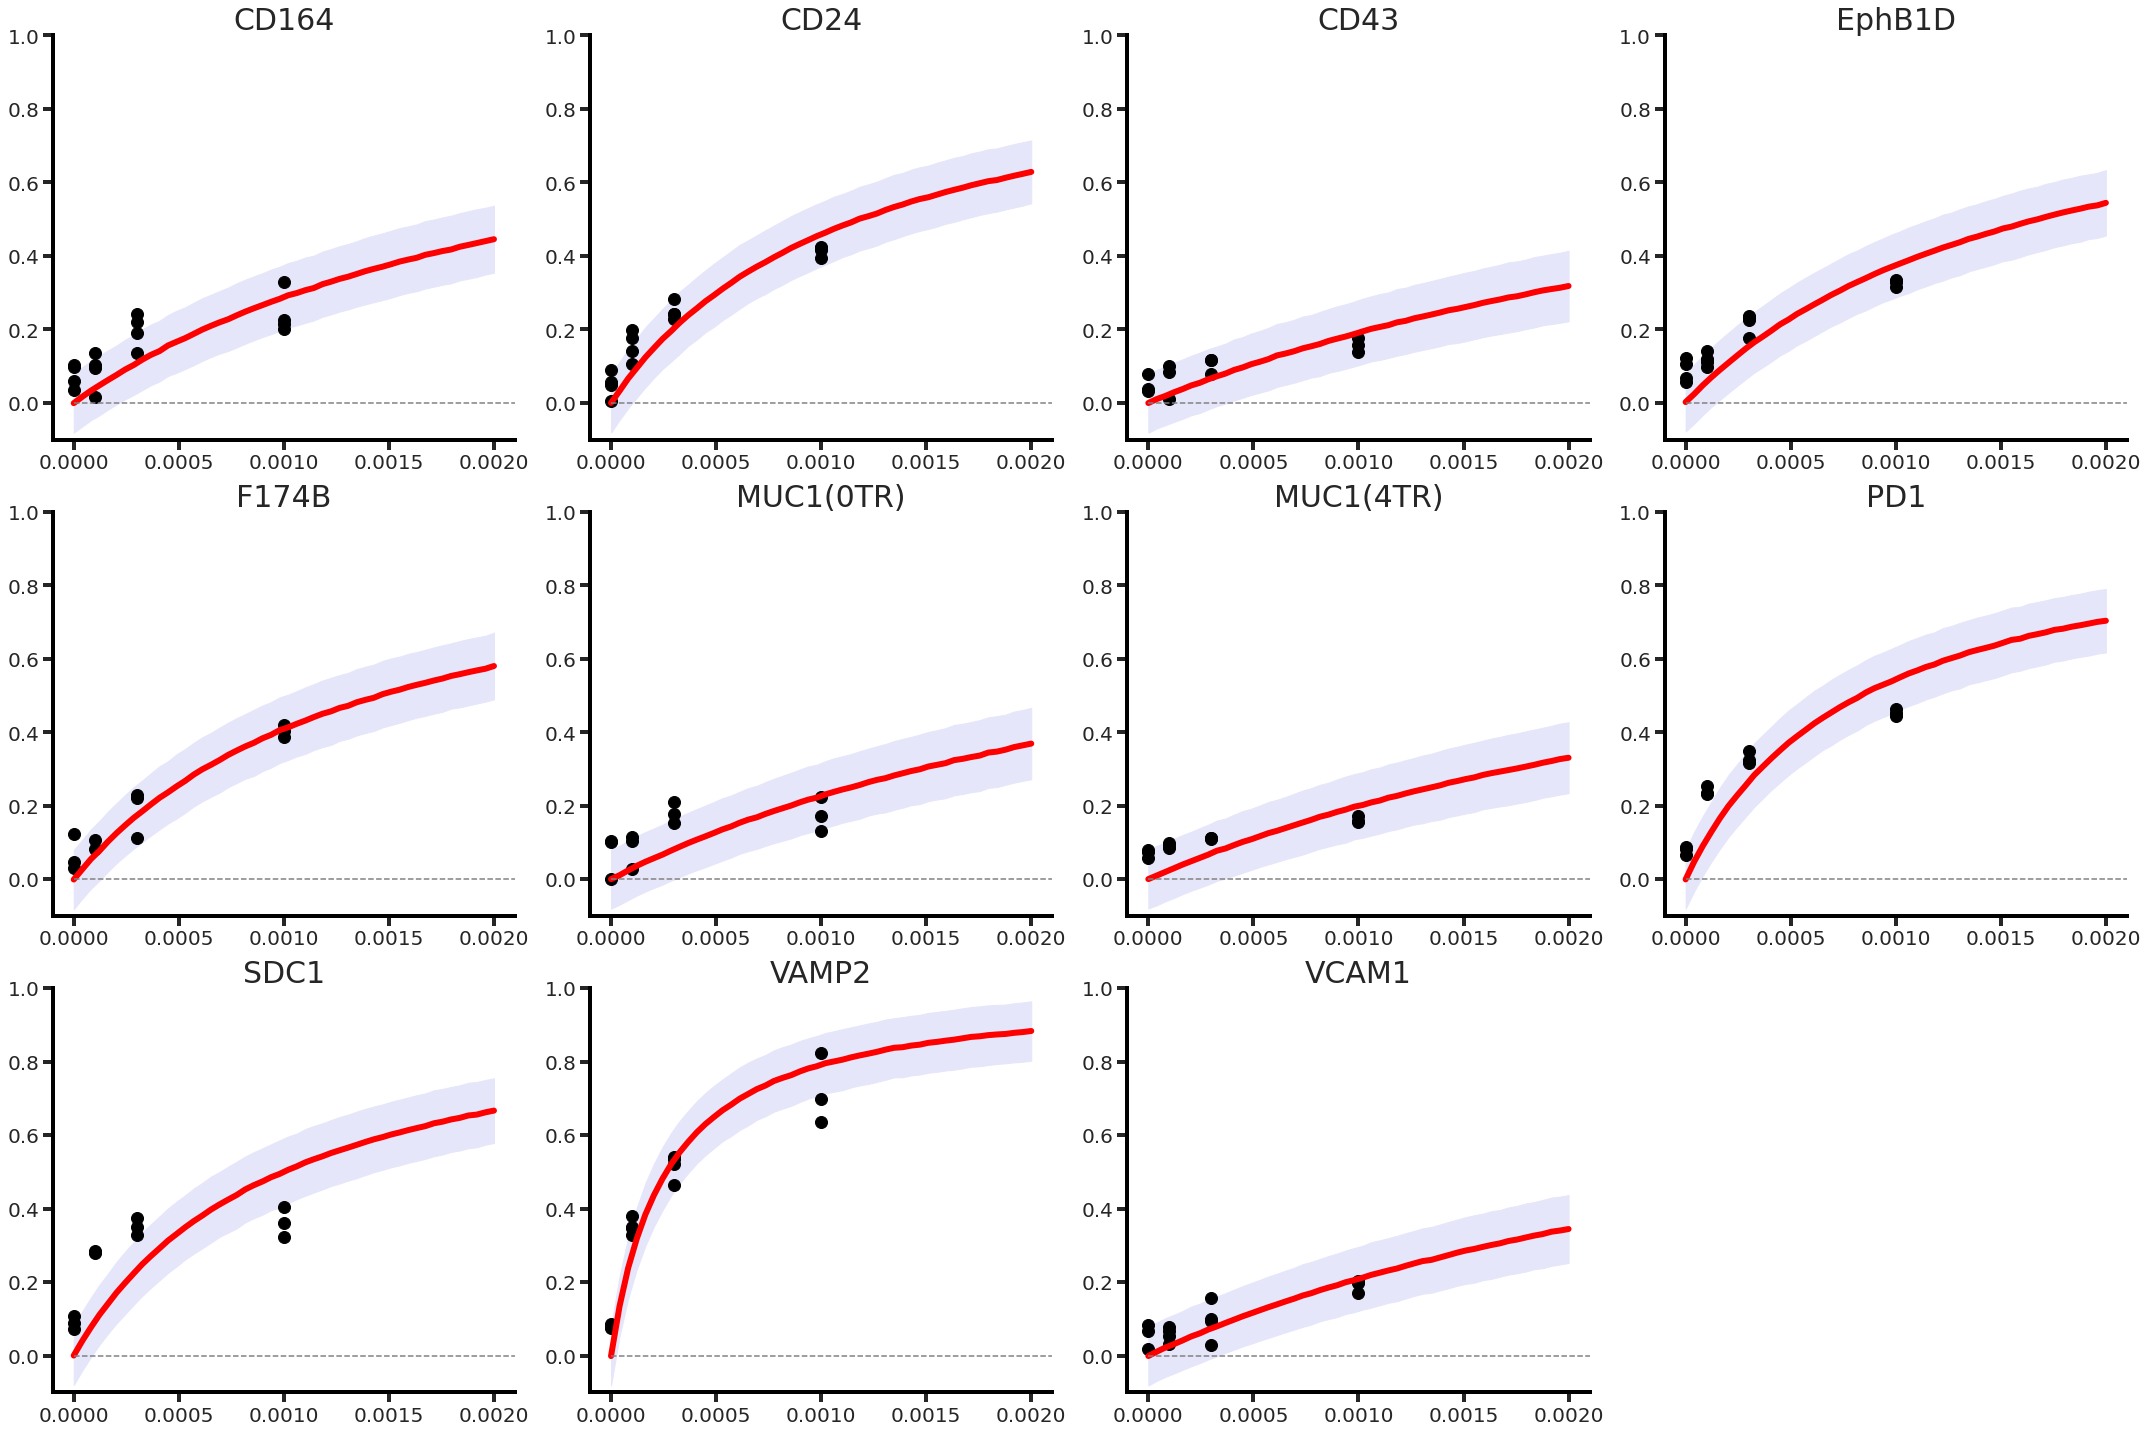

In [15]:
fig = plt.figure(figsize=(30, 20))

for k in range(N_Mol_ID):
    ax = fig.add_subplot(3, 4, k+1)
    
    uMoltemp = u_Mol_ID[u_Mol_ID['Mol_ID']==k]
    Mol_Name= uMoltemp.iloc[0]['Protein']
    
    chart_predictions(Mol_Name, ax)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)

    ax.tick_params(width=4, length = 10, labelsize=20)
    ax.tick_params(which='minor', width=2, length=6)
    
    ax.set_title(Mol_Name, fontsize=30)

plt.tight_layout()
